<a href="https://colab.research.google.com/github/Jenfree/Vanguard_Capstone/blob/master/model/VAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install yfinance

  Created wheel for yfinance: filename=yfinance-0.1.50-py2.py3-none-any.whl size=21556 sha256=df0b12e3ac132cb30333e13423554903a6aa7ac7da799f5adf7d4c202f0f233b
  Stored in directory: /root/.cache/pip/wheels/19/2a/e6/b4d4cc977576e18220a36866acf2f2cf7241f16af5f8795b17
Successfully built yfinance


In [0]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import timedelta
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.base.datetools import dates_from_str
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import math

In [0]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
factor_matrix = np.loadtxt('/content/drive/My Drive/Capstone Data/factor_mat.csv')
factor_matrix = factor_matrix.T
factor_matrix.shape

(29325, 77)

In [0]:
company = pd.read_csv("/content/drive/My Drive/Capstone Data/company_table1.csv")
stock_ID = company['stock_ID'].tolist()
private_indices = [i for i, x in enumerate(stock_ID) if x == "private"]
stock_ID = [x for i, x in enumerate(stock_ID) if x != "private"]
new_factor = np.delete(factor_matrix, private_indices, 1)
new_factor.shape

(29325, 69)

In [0]:
news_guardian_entities = pd.read_csv('/content/drive/My Drive/Capstone Data/news_guardian_cuttedentity.csv')
df_factor = pd.DataFrame(data=new_factor, index=pd.to_datetime(news_guardian_entities.timestamp).dt.date, columns=stock_ID)

In [0]:
company = list(df_factor.columns)
company.remove('RDS.A')
company.remove('[005930]')
company.remove('LNKD (2016)')
company.remove('4938')

In [0]:
def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

In [0]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

[*********************100%***********************]  1 of 1 completed
Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Return ::  193.21    > 12.3212   =>   True
EBAY   ::  88.48     > 4.1296    =>   True
    Augmented Dickey-Fuller Test on "Return" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -28.6285
 No. Lags Chosen       = 0
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "EBAY" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -16.9546
 No. Lags Chosen       = 2
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


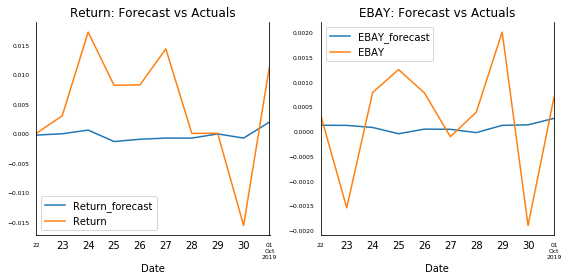

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


[*********************100%***********************]  1 of 1 completed
Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Return ::  211.88    > 12.3212   =>   True
BA     ::  99.83     > 4.1296    =>   True
    Augmented Dickey-Fuller Test on "Return" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -28.3406
 No. Lags Chosen       = 0
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "BA" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -23.9826
 No. Lags Chosen       = 0
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Va

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<Figure size 432x288 with 0 Axes>

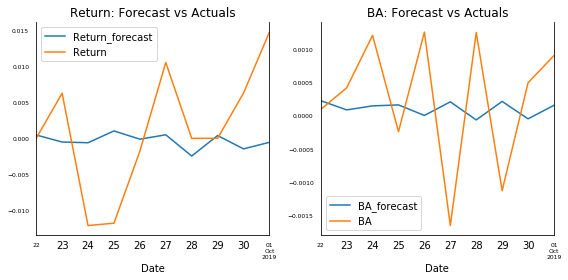

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


[*********************100%***********************]  1 of 1 completed
Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Return ::  216.92    > 12.3212   =>   True
EADSY  ::  101.04    > 4.1296    =>   True
    Augmented Dickey-Fuller Test on "Return" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -20.3335
 No. Lags Chosen       = 1
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "EADSY" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -24.7605
 No. Lags Chosen       = 0
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<Figure size 432x288 with 0 Axes>

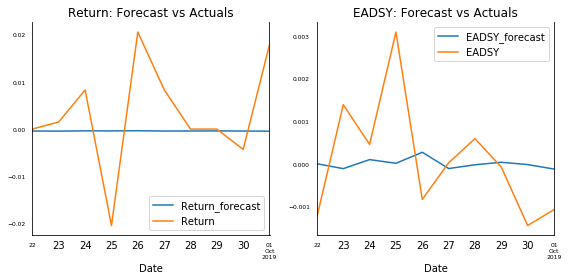

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


[*********************100%***********************]  1 of 1 completed
Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Return ::  195.42    > 12.3212   =>   True
TSCDY  ::  86.96     > 4.1296    =>   True
    Augmented Dickey-Fuller Test on "Return" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -26.6635
 No. Lags Chosen       = 0
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "TSCDY" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -10.7
 No. Lags Chosen       = 4
 Critical value 1%     = -3.44
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Val

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<Figure size 432x288 with 0 Axes>

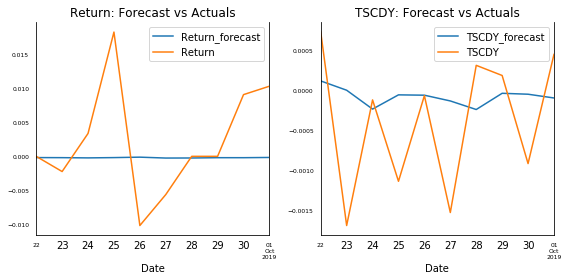

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


[*********************100%***********************]  1 of 1 completed
Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Return ::  200.75    > 12.3212   =>   True
DELL   ::  84.81     > 4.1296    =>   True
    Augmented Dickey-Fuller Test on "Return" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -10.2683
 No. Lags Chosen       = 6
 Critical value 1%     = -3.44
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "DELL" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -27.9915
 No. Lags Chosen       = 0
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-V

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<Figure size 432x288 with 0 Axes>

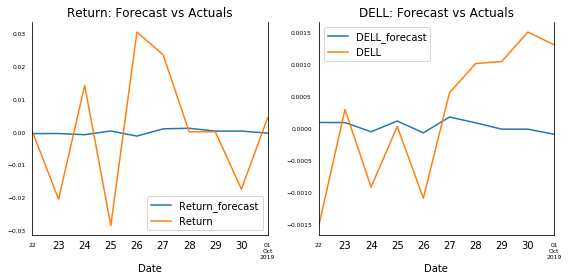

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


[*********************100%***********************]  1 of 1 completed
Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Return ::  203.01    > 12.3212   =>   True
FB     ::  89.78     > 4.1296    =>   True
    Augmented Dickey-Fuller Test on "Return" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -28.2485
 No. Lags Chosen       = 0
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "FB" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -24.0619
 No. Lags Chosen       = 0
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Va

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<Figure size 432x288 with 0 Axes>

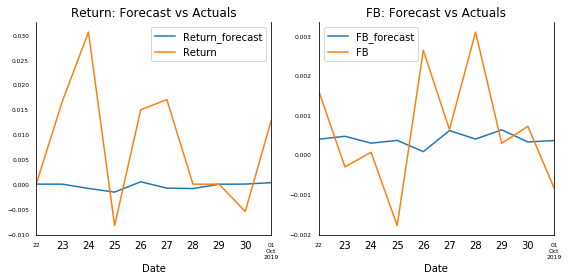

[*********************100%***********************]  1 of 1 completed

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)



Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Return ::  194.31    > 12.3212   =>   True
NFLX   ::  92.13     > 4.1296    =>   True
    Augmented Dickey-Fuller Test on "Return" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -10.198
 No. Lags Chosen       = 6
 Critical value 1%     = -3.44
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "NFLX" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -10.3358
 No. Lags Chosen       = 6
 Critical value 1%     = -3.44
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


  S

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<Figure size 432x288 with 0 Axes>

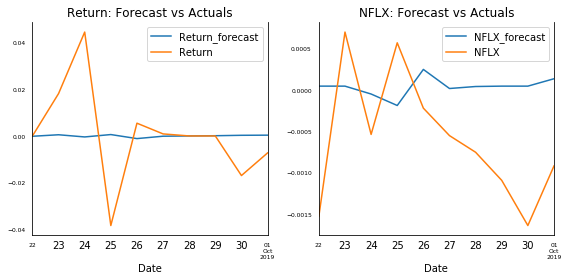

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Return ::  191.12    > 12.3212   =>   True
AMZN   ::  79.16     > 4.1296    =>   True
    Augmented Dickey-Fuller Test on "Return" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -15.0509
 No. Lags Chosen       = 2
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "AMZN" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -25.9087
 No. Lags Chosen       = 0
 Critical value 1%     = -3.439
 

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<Figure size 432x288 with 0 Axes>

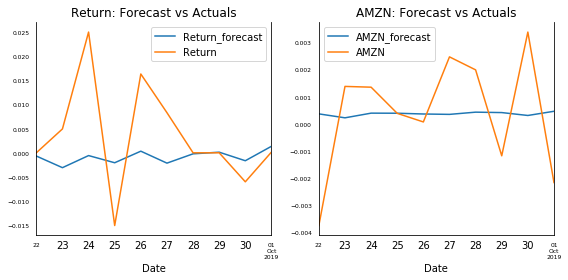

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


[*********************100%***********************]  1 of 1 completed
Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Return ::  207.34    > 12.3212   =>   True
TSLA   ::  89.67     > 4.1296    =>   True
    Augmented Dickey-Fuller Test on "Return" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -28.0539
 No. Lags Chosen       = 0
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "TSLA" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -14.8734
 No. Lags Chosen       = 2
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<Figure size 432x288 with 0 Axes>

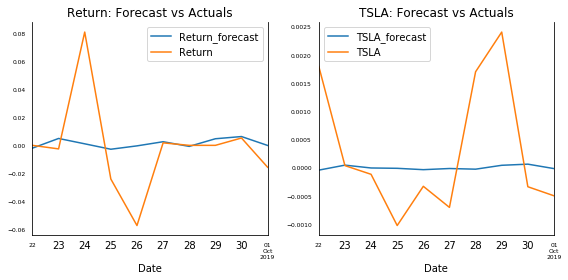

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


[*********************100%***********************]  1 of 1 completed
Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Return ::  222.55    > 12.3212   =>   True
F      ::  94.22     > 4.1296    =>   True
    Augmented Dickey-Fuller Test on "Return" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -28.7453
 No. Lags Chosen       = 0
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "F" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -24.0715
 No. Lags Chosen       = 0
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Val

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<Figure size 432x288 with 0 Axes>

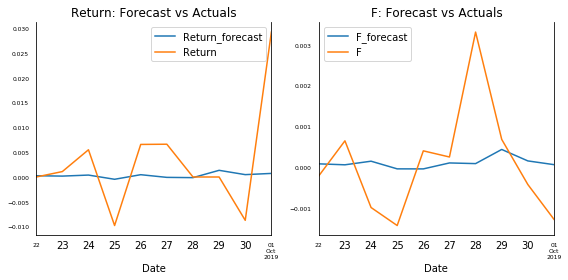

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


[*********************100%***********************]  1 of 1 completed
Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Return ::  207.89    > 12.3212   =>   True
NSANY  ::  101.73    > 4.1296    =>   True
    Augmented Dickey-Fuller Test on "Return" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -28.6343
 No. Lags Chosen       = 0
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "NSANY" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -25.8079
 No. Lags Chosen       = 0
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<Figure size 432x288 with 0 Axes>

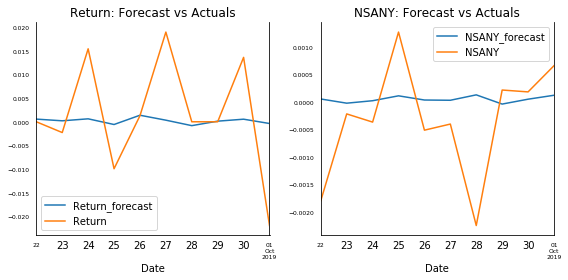

[*********************100%***********************]  1 of 1 completed

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)



Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Return ::  205.43    > 12.3212   =>   True
TM     ::  97.64     > 4.1296    =>   True
    Augmented Dickey-Fuller Test on "Return" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -28.0052
 No. Lags Chosen       = 0
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "TM" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -24.4303
 No. Lags Chosen       = 0
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<Figure size 432x288 with 0 Axes>

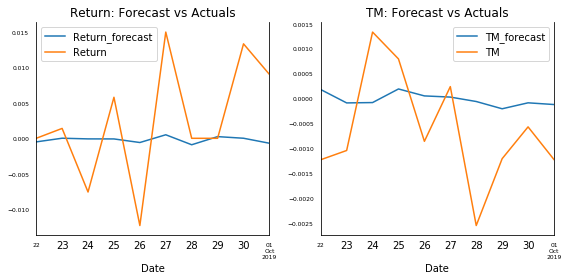

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


[*********************100%***********************]  1 of 1 completed
Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Return ::  204.96    > 12.3212   =>   True
HMC    ::  88.85     > 4.1296    =>   True
    Augmented Dickey-Fuller Test on "Return" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -25.4486
 No. Lags Chosen       = 0
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "HMC" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -25.3982
 No. Lags Chosen       = 0
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-V

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<Figure size 432x288 with 0 Axes>

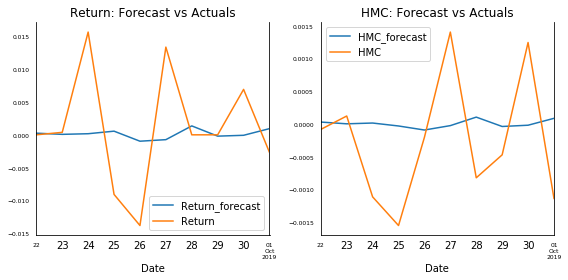

[*********************100%***********************]  1 of 1 completed

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)



Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Return ::  224.25    > 12.3212   =>   True
BMWYY  ::  109.69    > 4.1296    =>   True
    Augmented Dickey-Fuller Test on "Return" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -14.4438
 No. Lags Chosen       = 2
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "BMWYY" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -25.7893
 No. Lags Chosen       = 0
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.



/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<Figure size 432x288 with 0 Axes>

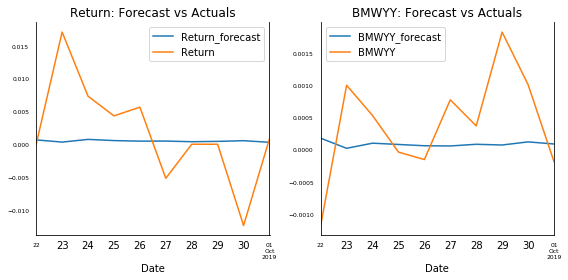

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Return ::  240.51    > 12.3212   =>   True
HSBC   ::  109.63    > 4.1296    =>   True
    Augmented Dickey-Fuller Test on "Return" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -27.6861
 No. Lags Chosen       = 0
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "HSBC" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -24.8058
 No. Lags Chosen       = 0
 Critical value 1%     = -3.439
 

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<Figure size 432x288 with 0 Axes>

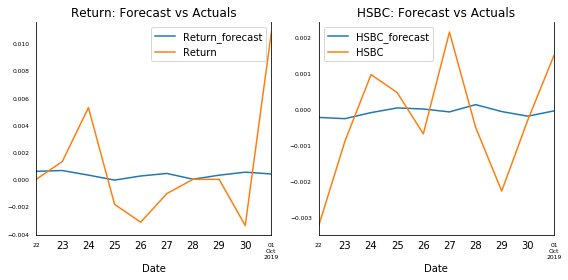

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


[*********************100%***********************]  1 of 1 completed
Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Return ::  201.29    > 12.3212   =>   True
AAPL   ::  92.58     > 4.1296    =>   True
    Augmented Dickey-Fuller Test on "Return" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.7183
 No. Lags Chosen       = 11
 Critical value 1%     = -3.44
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "AAPL" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -16.2561
 No. Lags Chosen       = 2
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-V

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<Figure size 432x288 with 0 Axes>

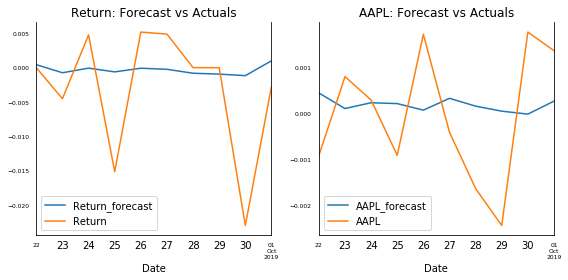

[*********************100%***********************]  1 of 1 completed

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)



Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Return ::  211.96    > 12.3212   =>   True
INTC   ::  96.25     > 4.1296    =>   True
    Augmented Dickey-Fuller Test on "Return" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -10.4601
 No. Lags Chosen       = 7
 Critical value 1%     = -3.44
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "INTC" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -17.3303
 No. Lags Chosen       = 1
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


 

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<Figure size 432x288 with 0 Axes>

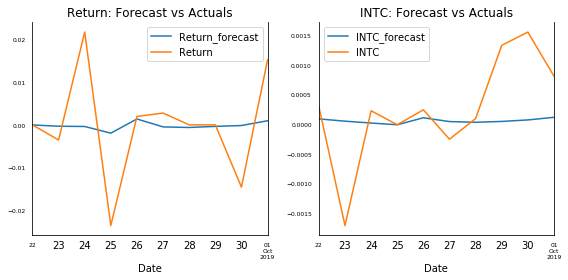

[*********************100%***********************]  1 of 1 completed

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)



Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Return ::  239.01    > 12.3212   =>   True
MSFT   ::  113.62    > 4.1296    =>   True
    Augmented Dickey-Fuller Test on "Return" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -11.812
 No. Lags Chosen       = 7
 Critical value 1%     = -3.44
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "MSFT" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -25.9075
 No. Lags Chosen       = 0
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<Figure size 432x288 with 0 Axes>

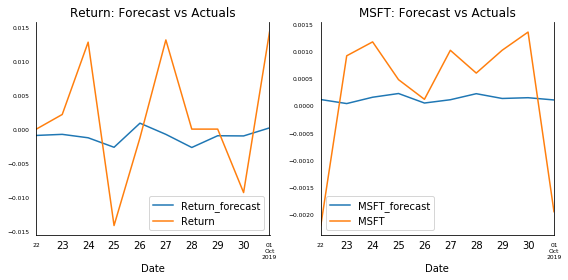

[*********************100%***********************]  1 of 1 completed

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)



Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Return ::  248.59    > 12.3212   =>   True
GS     ::  121.84    > 4.1296    =>   True
    Augmented Dickey-Fuller Test on "Return" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -13.7601
 No. Lags Chosen       = 2
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "GS" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -25.6509
 No. Lags Chosen       = 0
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<Figure size 432x288 with 0 Axes>

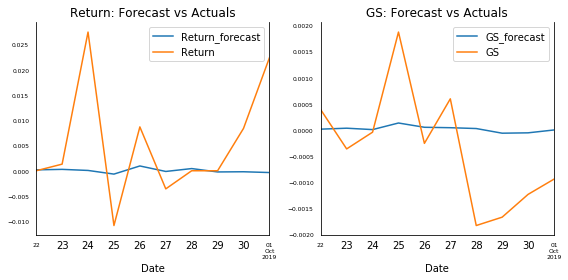

[*********************100%***********************]  1 of 1 completed

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)



Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Return ::  220.98    > 12.3212   =>   True
MS     ::  101.83    > 4.1296    =>   True
    Augmented Dickey-Fuller Test on "Return" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.5787
 No. Lags Chosen       = 10
 Critical value 1%     = -3.44
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "MS" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -24.4062
 No. Lags Chosen       = 0
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


  S

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<Figure size 432x288 with 0 Axes>

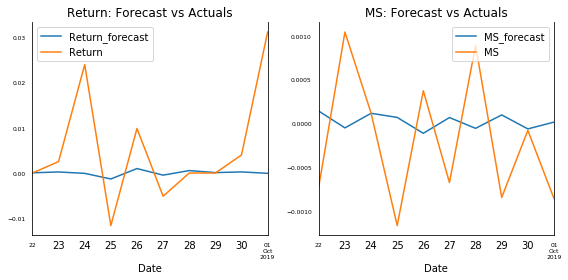

[*********************100%***********************]  1 of 1 completed

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)



Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Return ::  217.02    > 12.3212   =>   True
PTR    ::  100.96    > 4.1296    =>   True
    Augmented Dickey-Fuller Test on "Return" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -27.4328
 No. Lags Chosen       = 0
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "PTR" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -26.972
 No. Lags Chosen       = 0
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<Figure size 432x288 with 0 Axes>

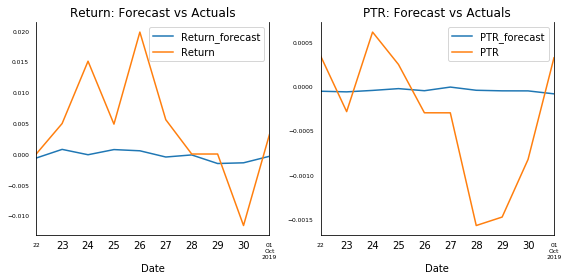

[*********************100%***********************]  1 of 1 completed

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)



Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Return ::  225.62    > 12.3212   =>   True
SNE    ::  108.94    > 4.1296    =>   True
    Augmented Dickey-Fuller Test on "Return" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -28.1864
 No. Lags Chosen       = 0
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "SNE" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -17.5887
 No. Lags Chosen       = 1
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


 

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<Figure size 432x288 with 0 Axes>

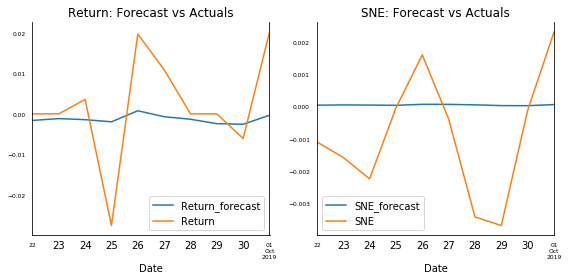

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


[*********************100%***********************]  1 of 1 completed
Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Return ::  202.08    > 12.3212   =>   True
HPQ    ::  94.25     > 4.1296    =>   True
    Augmented Dickey-Fuller Test on "Return" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -13.7273
 No. Lags Chosen       = 2
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "HPQ" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -17.1498
 No. Lags Chosen       = 1
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-V

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<Figure size 432x288 with 0 Axes>

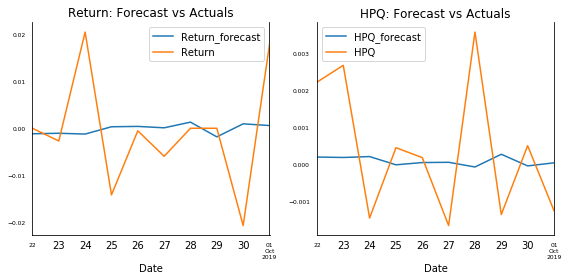

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


[*********************100%***********************]  1 of 1 completed
Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Return ::  237.57    > 12.3212   =>   True
SIEGY  ::  99.27     > 4.1296    =>   True
    Augmented Dickey-Fuller Test on "Return" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -26.6162
 No. Lags Chosen       = 0
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "SIEGY" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -10.9957
 No. Lags Chosen       = 7
 Critical value 1%     = -3.44
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<Figure size 432x288 with 0 Axes>

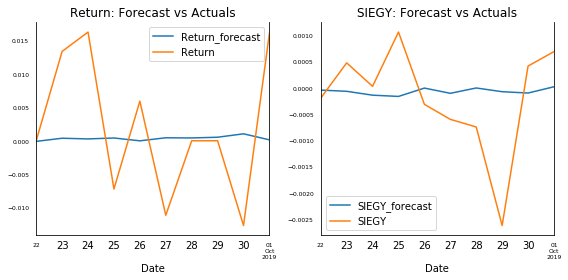

[*********************100%***********************]  1 of 1 completed

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)



Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Return ::  227.19    > 12.3212   =>   True
IBM    ::  108.09    > 4.1296    =>   True
    Augmented Dickey-Fuller Test on "Return" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -27.3616
 No. Lags Chosen       = 0
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "IBM" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -25.9557
 No. Lags Chosen       = 0
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


 

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<Figure size 432x288 with 0 Axes>

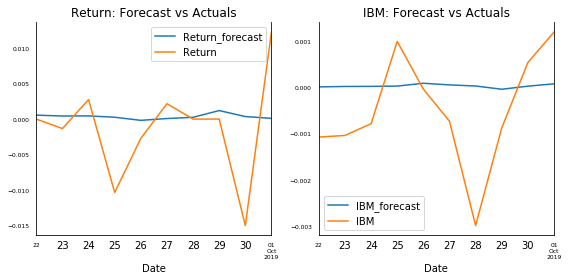

[*********************100%***********************]  1 of 1 completed

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)



Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Return ::  207.83    > 12.3212   =>   True
VWAGY  ::  93.98     > 4.1296    =>   True
    Augmented Dickey-Fuller Test on "Return" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -14.4949
 No. Lags Chosen       = 2
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "VWAGY" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -25.0528
 No. Lags Chosen       = 0
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.



/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<Figure size 432x288 with 0 Axes>

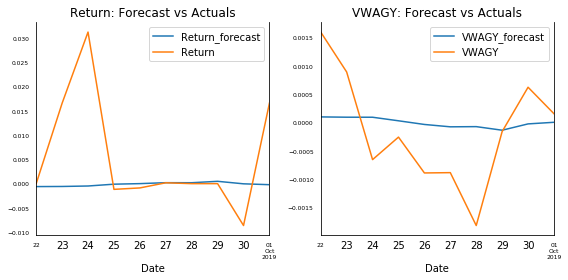

[*********************100%***********************]  1 of 1 completed

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)



Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Return ::  253.53    > 12.3212   =>   True
ADBE   ::  108.99    > 4.1296    =>   True
    Augmented Dickey-Fuller Test on "Return" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -21.5074
 No. Lags Chosen       = 1
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "ADBE" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -26.2404
 No. Lags Chosen       = 0
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.




/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<Figure size 432x288 with 0 Axes>

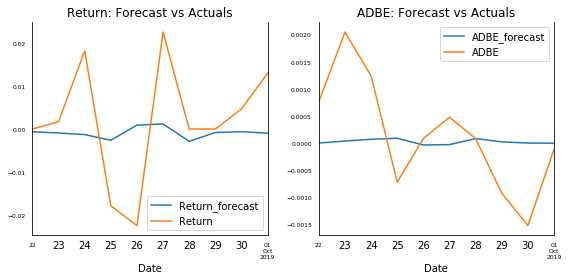

[*********************100%***********************]  1 of 1 completed

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)



Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Return ::  206.41    > 12.3212   =>   True
UBS    ::  96.08     > 4.1296    =>   True
    Augmented Dickey-Fuller Test on "Return" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -25.9337
 No. Lags Chosen       = 0
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "UBS" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -24.4957
 No. Lags Chosen       = 0
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


 

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<Figure size 432x288 with 0 Axes>

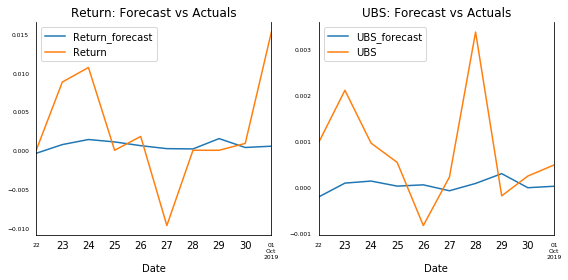

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


[*********************100%***********************]  1 of 1 completed
Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Return ::  222.04    > 12.3212   =>   True
CAT    ::  98.24     > 4.1296    =>   True
    Augmented Dickey-Fuller Test on "Return" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -26.0614
 No. Lags Chosen       = 0
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "CAT" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -26.4141
 No. Lags Chosen       = 0
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-V

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<Figure size 432x288 with 0 Axes>

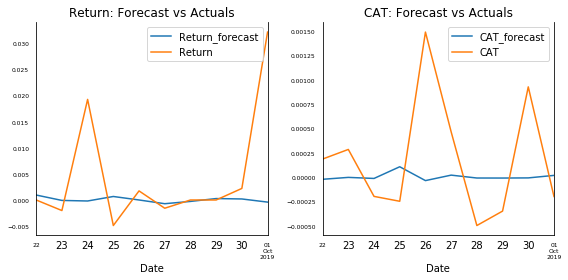

[*********************100%***********************]  1 of 1 completed

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)



Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Return ::  218.16    > 12.3212   =>   True
WFC    ::  101.05    > 4.1296    =>   True
    Augmented Dickey-Fuller Test on "Return" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -13.9919
 No. Lags Chosen       = 2
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "WFC" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -25.364
 No. Lags Chosen       = 0
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<Figure size 432x288 with 0 Axes>

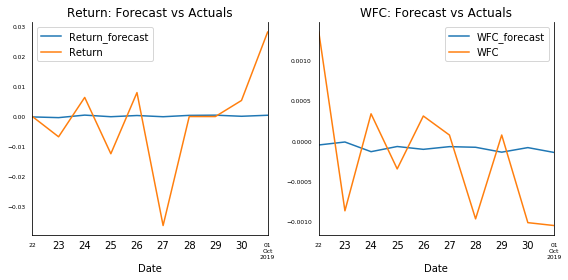

[*********************100%***********************]  1 of 1 completed

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)



Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Return ::  261.03    > 12.3212   =>   True
AXP    ::  120.28    > 4.1296    =>   True
    Augmented Dickey-Fuller Test on "Return" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -11.1371
 No. Lags Chosen       = 7
 Critical value 1%     = -3.44
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "AXP" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -26.1746
 No. Lags Chosen       = 0
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<Figure size 432x288 with 0 Axes>

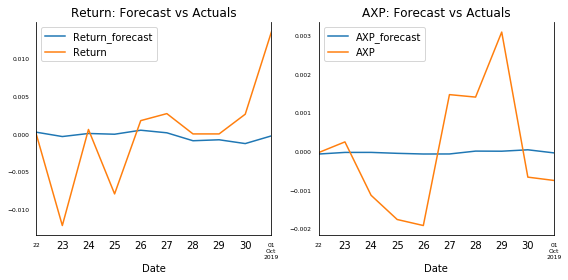

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


[*********************100%***********************]  1 of 1 completed
Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Return ::  200.11    > 12.3212   =>   True
BAC    ::  90.8      > 4.1296    =>   True
    Augmented Dickey-Fuller Test on "Return" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -13.9776
 No. Lags Chosen       = 2
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "BAC" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -23.7982
 No. Lags Chosen       = 0
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-V

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<Figure size 432x288 with 0 Axes>

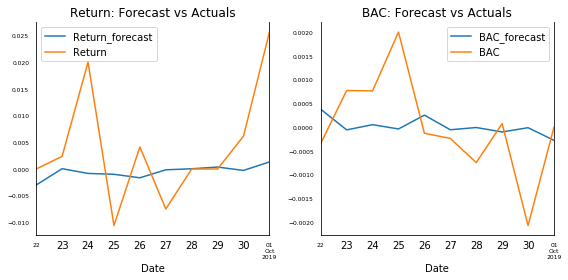

[*********************100%***********************]  1 of 1 completed

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)



Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Return ::  214.06    > 12.3212   =>   True
HPE    ::  97.38     > 4.1296    =>   True
    Augmented Dickey-Fuller Test on "Return" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -13.868
 No. Lags Chosen       = 2
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "HPE" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -25.4488
 No. Lags Chosen       = 0
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<Figure size 432x288 with 0 Axes>

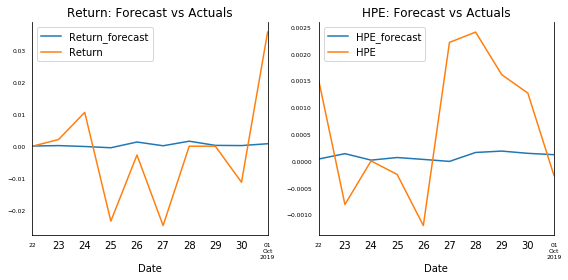

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Return ::  194.24    > 12.3212   =>   True
C      ::  92.87     > 4.1296    =>   True
    Augmented Dickey-Fuller Test on "Return" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -13.7148
 No. Lags Chosen       = 2
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "C" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -18.8939
 No. Lags Chosen       = 1
 Critical value 1%     = -3.439
 Cri

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<Figure size 432x288 with 0 Axes>

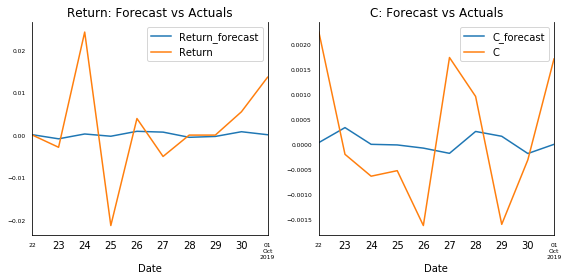

[*********************100%***********************]  1 of 1 completed

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)



Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Return ::  206.0     > 12.3212   =>   True
HTHIY  ::  99.63     > 4.1296    =>   True
    Augmented Dickey-Fuller Test on "Return" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -11.7263
 No. Lags Chosen       = 3
 Critical value 1%     = -3.44
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "HTHIY" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -25.5374
 No. Lags Chosen       = 0
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.




/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<Figure size 432x288 with 0 Axes>

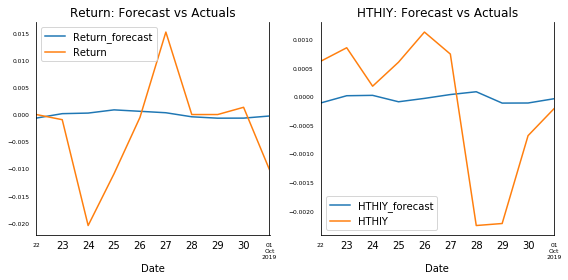

[*********************100%***********************]  1 of 1 completed

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)



Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Return ::  218.52    > 12.3212   =>   True
BP     ::  99.61     > 4.1296    =>   True
    Augmented Dickey-Fuller Test on "Return" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -28.0061
 No. Lags Chosen       = 0
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "BP" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -27.1148
 No. Lags Chosen       = 0
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<Figure size 432x288 with 0 Axes>

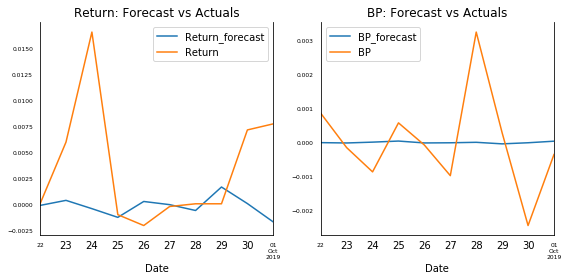

[*********************100%***********************]  1 of 1 completed

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)



Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Return ::  222.42    > 12.3212   =>   True
JPM    ::  110.28    > 4.1296    =>   True
    Augmented Dickey-Fuller Test on "Return" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -18.1969
 No. Lags Chosen       = 1
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "JPM" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -24.5791
 No. Lags Chosen       = 0
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


 

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<Figure size 432x288 with 0 Axes>

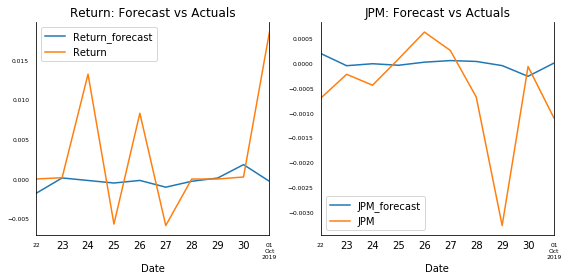

[*********************100%***********************]  1 of 1 completed

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)



Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Return ::  206.94    > 12.3212   =>   True
BNPQY  ::  89.81     > 4.1296    =>   True
    Augmented Dickey-Fuller Test on "Return" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -27.1118
 No. Lags Chosen       = 0
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "BNPQY" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -24.2516
 No. Lags Chosen       = 0
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.



/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<Figure size 432x288 with 0 Axes>

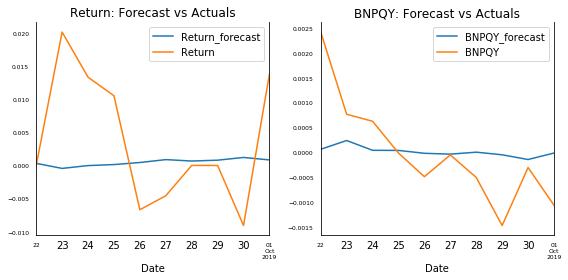

[*********************100%***********************]  1 of 1 completed

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)



Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Return ::  233.89    > 12.3212   =>   True
ORCL   ::  113.45    > 4.1296    =>   True
    Augmented Dickey-Fuller Test on "Return" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -28.4874
 No. Lags Chosen       = 0
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "ORCL" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -24.602
 No. Lags Chosen       = 0
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


 

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<Figure size 432x288 with 0 Axes>

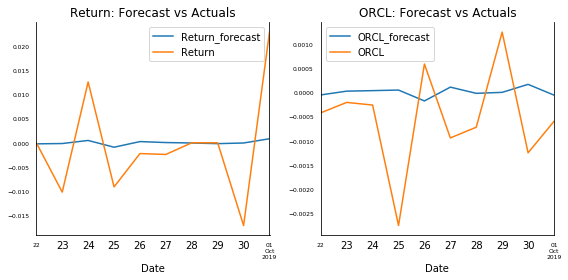

[*********************100%***********************]  1 of 1 completed

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)



Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Return ::  222.43    > 12.3212   =>   True
MUFG   ::  93.27     > 4.1296    =>   True
    Augmented Dickey-Fuller Test on "Return" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -14.0499
 No. Lags Chosen       = 2
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "MUFG" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -11.8751
 No. Lags Chosen       = 5
 Critical value 1%     = -3.44
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


 

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<Figure size 432x288 with 0 Axes>

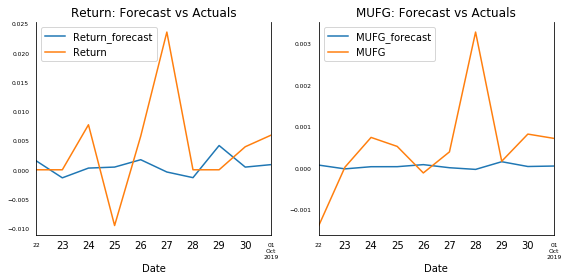

[*********************100%***********************]  1 of 1 completed

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)



Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Return ::  214.06    > 12.3212   =>   True
LNVGY  ::  83.94     > 4.1296    =>   True
    Augmented Dickey-Fuller Test on "Return" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -9.7575
 No. Lags Chosen       = 6
 Critical value 1%     = -3.44
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "LNVGY" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -24.6611
 No. Lags Chosen       = 0
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


 

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<Figure size 432x288 with 0 Axes>

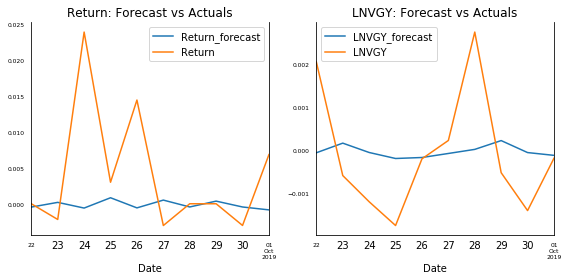

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


[*********************100%***********************]  1 of 1 completed
Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Return ::  203.38    > 12.3212   =>   True
GE     ::  82.7      > 4.1296    =>   True
    Augmented Dickey-Fuller Test on "Return" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -14.8041
 No. Lags Chosen       = 2
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "GE" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -19.6671
 No. Lags Chosen       = 1
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Va

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<Figure size 432x288 with 0 Axes>

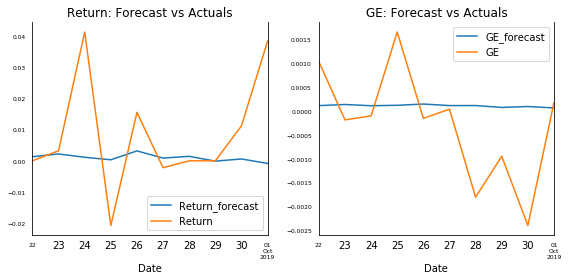

[*********************100%***********************]  1 of 1 completed

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)



Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Return ::  222.13    > 12.3212   =>   True
ACN    ::  109.14    > 4.1296    =>   True
    Augmented Dickey-Fuller Test on "Return" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -27.1234
 No. Lags Chosen       = 0
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "ACN" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -25.4907
 No. Lags Chosen       = 0
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


 

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<Figure size 432x288 with 0 Axes>

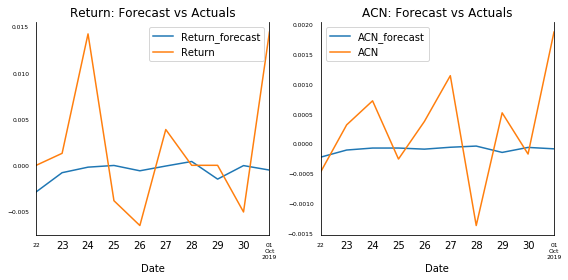

[*********************100%***********************]  1 of 1 completed

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)



Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Return ::  229.29    > 12.3212   =>   True
CSCO   ::  110.59    > 4.1296    =>   True
    Augmented Dickey-Fuller Test on "Return" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -13.8259
 No. Lags Chosen       = 3
 Critical value 1%     = -3.44
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "CSCO" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -24.9135
 No. Lags Chosen       = 0
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


 

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<Figure size 432x288 with 0 Axes>

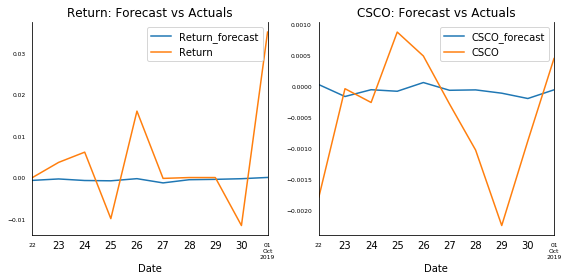

[*********************100%***********************]  1 of 1 completed

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)



Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Return ::  227.67    > 12.3212   =>   True
SHI    ::  109.19    > 4.1296    =>   True
    Augmented Dickey-Fuller Test on "Return" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -27.2382
 No. Lags Chosen       = 0
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "SHI" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -13.7036
 No. Lags Chosen       = 3
 Critical value 1%     = -3.44
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<Figure size 432x288 with 0 Axes>

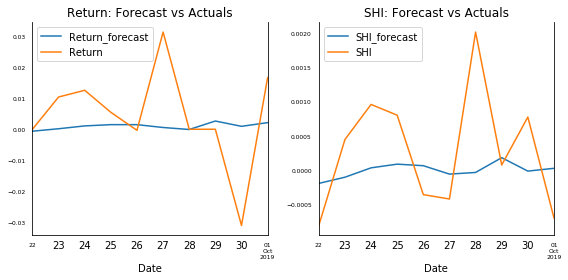

[*********************100%***********************]  1 of 1 completed

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)



Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Return ::  219.32    > 12.3212   =>   True
FJTSY  ::  94.54     > 4.1296    =>   True
    Augmented Dickey-Fuller Test on "Return" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -11.4808
 No. Lags Chosen       = 5
 Critical value 1%     = -3.44
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "FJTSY" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -28.1581
 No. Lags Chosen       = 0
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.




/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<Figure size 432x288 with 0 Axes>

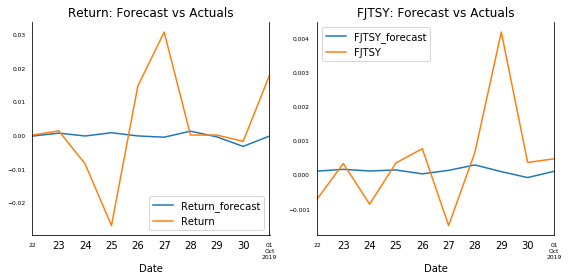

[*********************100%***********************]  1 of 1 completed

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)



Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Return ::  230.2     > 12.3212   =>   True
SAP    ::  110.89    > 4.1296    =>   True
    Augmented Dickey-Fuller Test on "Return" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -28.7412
 No. Lags Chosen       = 0
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "SAP" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -17.9396
 No. Lags Chosen       = 1
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


 

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<Figure size 432x288 with 0 Axes>

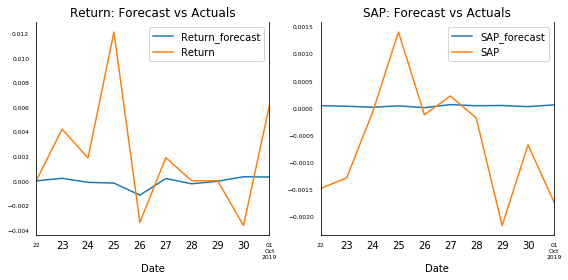

[*********************100%***********************]  1 of 1 completed

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)



Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Return ::  193.91    > 12.3212   =>   True
TCEHY  ::  80.82     > 4.1296    =>   True
    Augmented Dickey-Fuller Test on "Return" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -8.5279
 No. Lags Chosen       = 11
 Critical value 1%     = -3.44
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "TCEHY" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -23.7252
 No. Lags Chosen       = 0
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.




/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<Figure size 432x288 with 0 Axes>

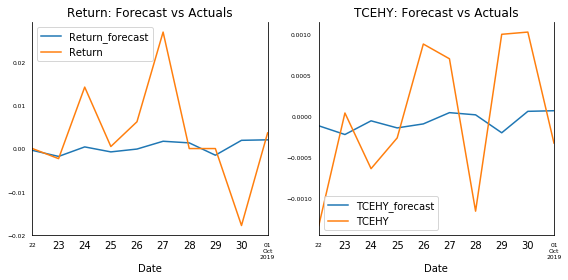

[*********************100%***********************]  1 of 1 completed

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)



Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Return ::  185.79    > 12.3212   =>   True
PNC    ::  83.69     > 4.1296    =>   True
    Augmented Dickey-Fuller Test on "Return" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -17.4467
 No. Lags Chosen       = 1
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "PNC" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -9.3339
 No. Lags Chosen       = 5
 Critical value 1%     = -3.44
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


  S

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<Figure size 432x288 with 0 Axes>

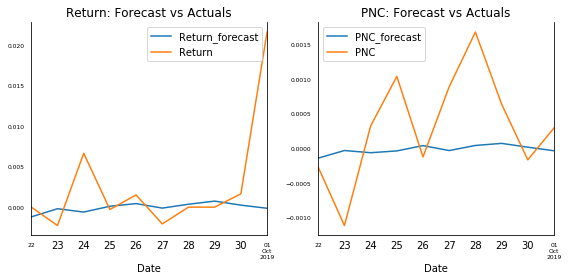

[*********************100%***********************]  1 of 1 completed

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)



Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Return ::  202.96    > 12.3212   =>   True
COP    ::  96.74     > 4.1296    =>   True
    Augmented Dickey-Fuller Test on "Return" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -28.6934
 No. Lags Chosen       = 0
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "COP" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -26.7153
 No. Lags Chosen       = 0
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


 

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<Figure size 432x288 with 0 Axes>

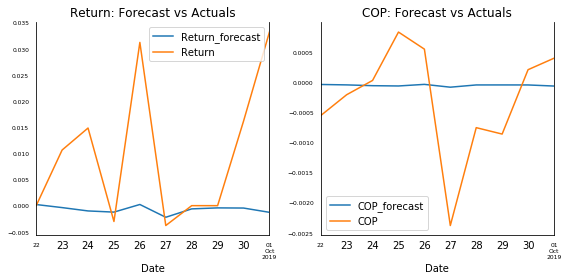

[*********************100%***********************]  1 of 1 completed

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)



Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Return ::  226.28    > 12.3212   =>   True
CRM    ::  107.86    > 4.1296    =>   True
    Augmented Dickey-Fuller Test on "Return" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -28.5635
 No. Lags Chosen       = 0
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "CRM" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -17.2082
 No. Lags Chosen       = 1
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


 

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<Figure size 432x288 with 0 Axes>

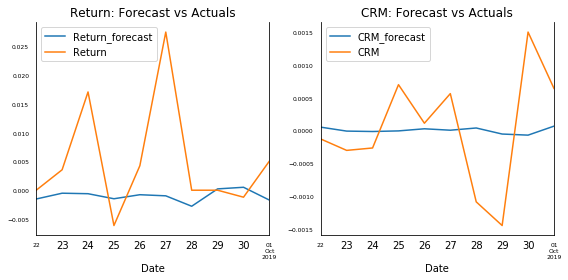

[*********************100%***********************]  1 of 1 completed

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)



Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Return ::  235.45    > 12.3212   =>   True
AVGO   ::  112.52    > 4.1296    =>   True
    Augmented Dickey-Fuller Test on "Return" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -13.5944
 No. Lags Chosen       = 3
 Critical value 1%     = -3.44
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "AVGO" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -26.4604
 No. Lags Chosen       = 0
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


 

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<Figure size 432x288 with 0 Axes>

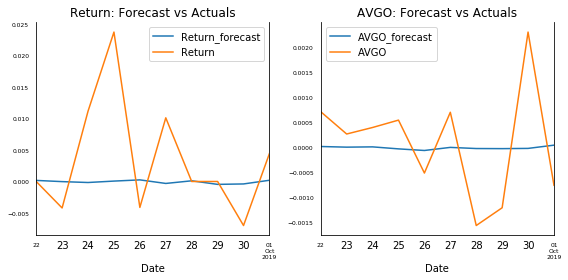

[*********************100%***********************]  1 of 1 completed

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)



Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Return ::  212.61    > 12.3212   =>   True
HON    ::  96.12     > 4.1296    =>   True
    Augmented Dickey-Fuller Test on "Return" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -27.8054
 No. Lags Chosen       = 0
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "HON" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -17.0612
 No. Lags Chosen       = 1
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


 

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<Figure size 432x288 with 0 Axes>

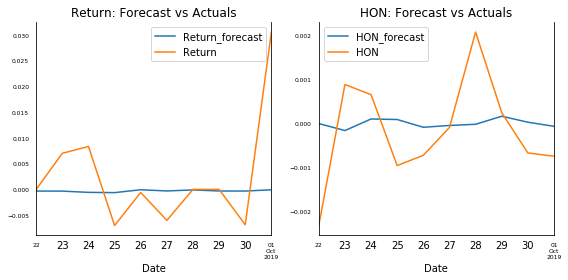

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Return ::  214.84    > 12.3212   =>   True
COF    ::  92.81     > 4.1296    =>   True
    Augmented Dickey-Fuller Test on "Return" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -12.9422
 No. Lags Chosen       = 3
 Critical value 1%     = -3.44
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "COF" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -25.0655
 No. Lags Chosen       = 0
 Critical value 1%     = -3.439
 Cr

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<Figure size 432x288 with 0 Axes>

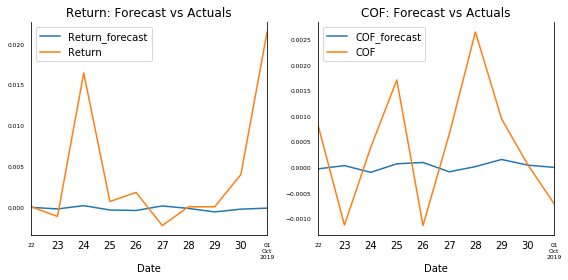

[*********************100%***********************]  1 of 1 completed

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)



Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Return ::  217.12    > 12.3212   =>   True
STFGX  ::  98.99     > 4.1296    =>   True
    Augmented Dickey-Fuller Test on "Return" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -10.835
 No. Lags Chosen       = 7
 Critical value 1%     = -3.44
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "STFGX" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -26.1073
 No. Lags Chosen       = 0
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


 

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<Figure size 432x288 with 0 Axes>

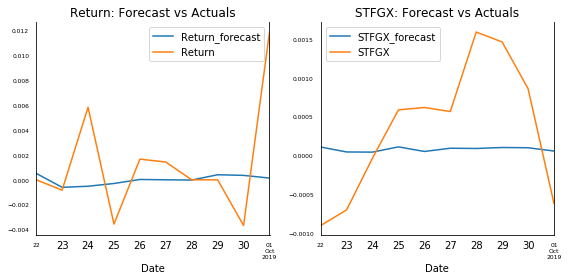

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


[*********************100%***********************]  1 of 1 completed
Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Return ::  241.92    > 12.3212   =>   True
CVX    ::  103.53    > 4.1296    =>   True
    Augmented Dickey-Fuller Test on "Return" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -13.6616
 No. Lags Chosen       = 3
 Critical value 1%     = -3.44
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "CVX" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -19.8244
 No. Lags Chosen       = 1
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Va

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<Figure size 432x288 with 0 Axes>

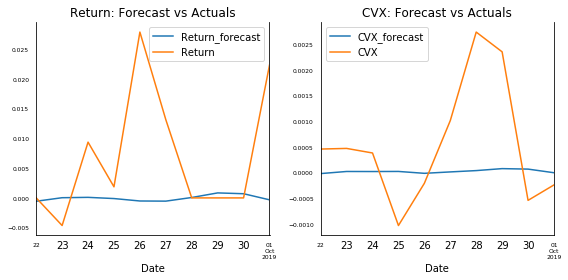

[*********************100%***********************]  1 of 1 completed

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)



Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Return ::  229.94    > 12.3212   =>   True
CAKE   ::  112.3     > 4.1296    =>   True
    Augmented Dickey-Fuller Test on "Return" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -27.1402
 No. Lags Chosen       = 0
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "CAKE" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -26.3801
 No. Lags Chosen       = 0
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.




/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<Figure size 432x288 with 0 Axes>

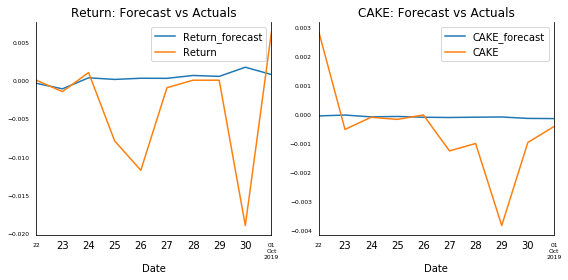

[*********************100%***********************]  1 of 1 completed

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)



Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Return ::  190.44    > 12.3212   =>   True
PSX    ::  86.35     > 4.1296    =>   True
    Augmented Dickey-Fuller Test on "Return" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.0686
 No. Lags Chosen       = 9
 Critical value 1%     = -3.44
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "PSX" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -16.9687
 No. Lags Chosen       = 1
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


  S

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<Figure size 432x288 with 0 Axes>

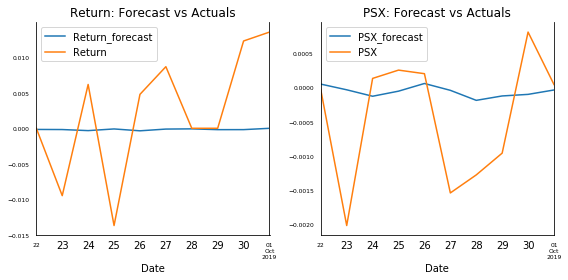

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


[*********************100%***********************]  1 of 1 completed
Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Return ::  216.69    > 12.3212   =>   True
HAL    ::  97.94     > 4.1296    =>   True
    Augmented Dickey-Fuller Test on "Return" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -24.8344
 No. Lags Chosen       = 0
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "HAL" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -24.6449
 No. Lags Chosen       = 0
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-V

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<Figure size 432x288 with 0 Axes>

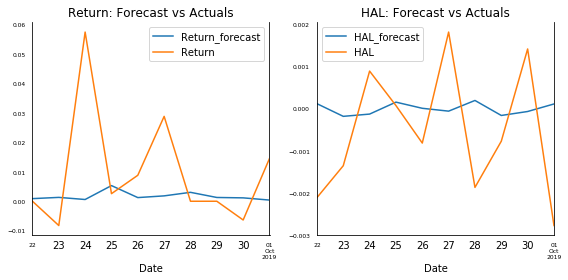

[*********************100%***********************]  1 of 1 completed

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)



Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Return ::  222.38    > 12.3212   =>   True
UTX    ::  98.13     > 4.1296    =>   True
    Augmented Dickey-Fuller Test on "Return" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -29.1026
 No. Lags Chosen       = 0
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "UTX" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -26.7081
 No. Lags Chosen       = 0
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


 

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<Figure size 432x288 with 0 Axes>

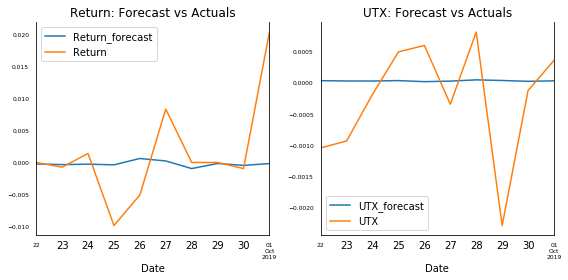

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


[*********************100%***********************]  1 of 1 completed
Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Return ::  202.88    > 12.3212   =>   True
TXN    ::  90.18     > 4.1296    =>   True
    Augmented Dickey-Fuller Test on "Return" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.5155
 No. Lags Chosen       = 14
 Critical value 1%     = -3.44
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "TXN" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -25.1739
 No. Lags Chosen       = 0
 Critical value 1%     = -3.439
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Va

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<Figure size 432x288 with 0 Axes>

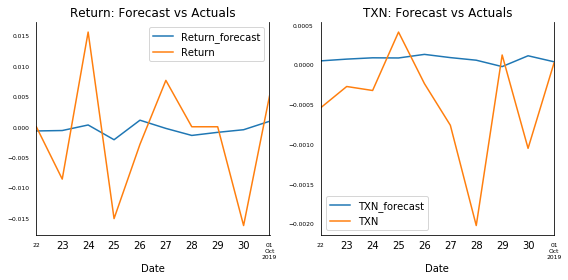

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<Figure size 432x288 with 0 Axes>

In [0]:
var_list = []
ar_list = []

for name in company:
  FB_sentiment = df_factor.groupby('timestamp')[name].mean().reset_index()
  data = yf.download(name, start="2017-09-28", end="2019-10-02")

  count = 0
  irow = 0
  while irow < data.shape[0] - 1:
    next_date = data.iloc[irow,:].name + timedelta(days=1)
    if next_date not in data.index:
      count += 1
      data.loc[next_date] = data.iloc[irow, :]
      data = data.sort_index()
    irow += 1
  data_sorted = data.sort_index()
  #create a new column for return 
  data_sorted.insert(6, 'Return', 1)
  for i in range(1, data_sorted.shape[0]):
    return_val = data_sorted.iloc[i-1, 4] / data_sorted.iloc[i, 4] - 1
    data_sorted.iloc[i, 6] = return_val
  data_sorted = data_sorted.iloc[3:, :]
  FB_sentiment = FB_sentiment.set_index("timestamp")
  final_FB = data_sorted.join(FB_sentiment)
  final_FB = final_FB.iloc[:,6:]
  final_FB = final_FB.fillna(0)
  try:
    cointegration_test(final_FB)
    nobs = 10
    df_train, df_test = final_FB[0:-nobs], final_FB[-nobs:]
    for name, column in df_train.iteritems():
        adfuller_test(column, name=column.name)
        print('\n')
    model = VAR(df_train)
    # x = model.select_order(maxlags=12)
    # print(x.summary())
    model_fitted = model.fit()
    print(model_fitted.summary())

    lag_order = model_fitted.k_ar

    # Input data for forecasting
    forecast_input = df_train.values[-lag_order:]
    fc = model_fitted.forecast(y=forecast_input, steps=1)
    forecast_input = np.concatenate((forecast_input, df_test.values), axis=0)
    for i in range(nobs-1):
      fc = np.concatenate((fc, model_fitted.forecast(y=forecast_input[i+1:i+1+lag_order], steps=1)), axis=0)
    df_results = pd.DataFrame(fc, index=final_FB.index[-nobs:], columns=final_FB.columns+'_forecast')
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
    for i, (col,ax) in enumerate(zip(final_FB.columns, axes.flatten())):
        df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
        df_test[col][-nobs:].plot(legend=True, ax=ax);
        ax.set_title(col + ": Forecast vs Actuals")
        ax.xaxis.set_ticks_position('none')
        ax.yaxis.set_ticks_position('none')
        ax.spines["top"].set_alpha(0)
        ax.tick_params(labelsize=6)

    plt.tight_layout();
    plt.show()
    plt.savefig(name+'.png')

    var_list.append(mean_squared_error(df_test['Return'], df_results['Return_forecast']))

    df_train = df_train['Return']
    df_test = df_test['Return']
    from statsmodels.tsa.ar_model import AR
    from sklearn.metrics import mean_squared_error

    # train autoregression
    model = AR(df_train)
    model_fit = model.fit()
    # print('Lag: %s' % model_fit.k_ar)
    # print('Coefficients: %s' % model_fit.params)
    # make predictions
    predictions = model_fit.predict(start=len(df_train), end=len(df_train)+len(df_test)-1, dynamic=False)
    error = mean_squared_error(df_test, predictions)
    ar_list.append(error)
    # print('Test MSE:', error)
  except:
    var_list.append(None)
    ar_list.append(None)

In [0]:
res = pd.DataFrame({"VAR":var_list, "AR":ar_list}, index = company)

In [0]:
finall = res[res['VAR']<=res['AR']]

In [0]:
finall.to_csv("AR&VAR.csv")

[*********************100%***********************]  1 of 1 completed


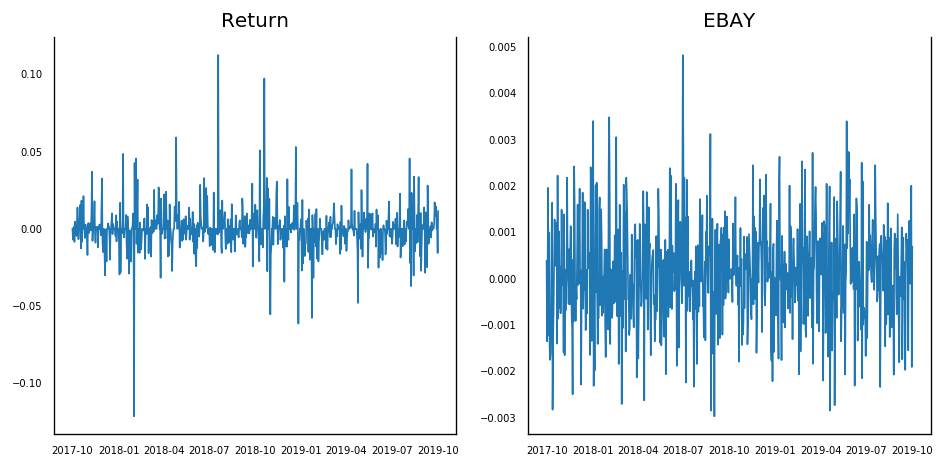

In [0]:
# Plot
name = 'EBAY'
FB_sentiment = df_factor.groupby('timestamp')[name].mean().reset_index()
data = yf.download(name, start="2017-09-28", end="2019-10-02")

count = 0
irow = 0
while irow < data.shape[0] - 1:
  next_date = data.iloc[irow,:].name + timedelta(days=1)
  if next_date not in data.index:
    count += 1
    data.loc[next_date] = data.iloc[irow, :]
    data = data.sort_index()
  irow += 1
data_sorted = data.sort_index()
#create a new column for return 
data_sorted.insert(6, 'Return', 1)
for i in range(1, data_sorted.shape[0]):
  return_val = data_sorted.iloc[i-1, 4] / data_sorted.iloc[i, 4] - 1
  data_sorted.iloc[i, 6] = return_val
data_sorted = data_sorted.iloc[3:, :]
FB_sentiment = FB_sentiment.set_index("timestamp")
final_FB = data_sorted.join(FB_sentiment)
final_FB = final_FB.iloc[:,6:]
final_FB = final_FB.fillna(0)
df = final_FB
fig, axes = plt.subplots(nrows=1, ncols=2, dpi=120, figsize=(8,4))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [0]:
res[res['VAR']<=res['AR']].index

Index(['EBAY', 'EADSY', 'DELL', 'AMZN', 'TSLA', 'F', 'NSANY', 'BMWYY', 'AAPL',
       'INTC', 'MSFT', 'PTR', 'SNE', 'IBM', 'ADBE', 'UBS', 'WFC', 'AXP', 'BAC',
       'HPE', 'C', 'HTHIY', 'JPM', 'ORCL', 'MUFG', 'GE', 'CSCO', 'SAP',
       'TCEHY', 'AVGO', 'HON', 'COF', 'STFGX', 'PSX', 'TXN'],
      dtype='object')

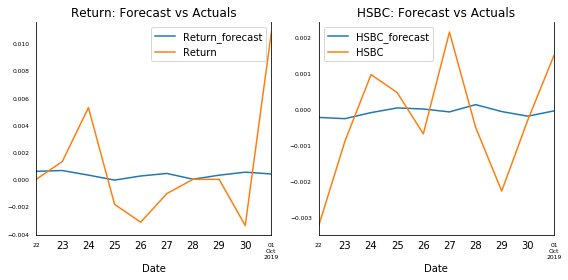

In [0]:
lag_order = model_fitted.k_ar

# Input data for forecasting
forecast_input = df_train.values[-lag_order:]
fc = model_fitted.forecast(y=forecast_input, steps=1)
forecast_input = np.concatenate((forecast_input, df_test.values), axis=0)
for i in range(nobs-1):
  fc = np.concatenate((fc, model_fitted.forecast(y=forecast_input[i+1:i+1+lag_order], steps=1)), axis=0)
df_results = pd.DataFrame(fc, index=final_FB.index[-nobs:], columns=final_FB.columns+'_forecast')
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
for i, (col,ax) in enumerate(zip(final_FB.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [0]:
mean_squared_error(df_test['Return'], df_results['Return_forecast'])

1.667763399175231e-05

In [0]:
df_train = df_train['Return']
df_test = df_test['Return']
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error

# train autoregression
model = AR(df_train)
model_fit = model.fit()
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)
# make predictions
predictions = model_fit.predict(start=len(df_train), end=len(df_train)+len(df_test)-1, dynamic=False)
error = mean_squared_error(df_test, predictions)
print('Test MSE:', error)